# ATML Project Report

### Group 2
Members: Léonard Barras & Nathan Gyger

Github: https://github.com/svapili/FS2019_ATML_Group2 

# Melanoma image classification
### Goal:
Implement a deep learning algorithm to classify mole pictures as benign or malignant using the [ISIC database](https://isic-archive.com/).

### Approach description:

- Class imbalance => data augmentation
- Images => CNN as a logical choice
- Transfer learning

### Procedure

- Augment the data for better balancing of classes (50-50 /33-67 ?)
- Train different CNN on a few epochs with different optimizer, learning rate and batch sizes.
- Select the more performant regarding different metrics: Accuracy, TP, TN ... Be sure that the problem of class unbalance has been corrected
- ? Fine tune ?
- ? Modify the argmax threshold in the output, Plot ROC Curve for different models ?
- Modify data augmentation for getting a better specificity

# Results
TODO: add accuracy table for different parameters

## Learning curve
TODO: add graphic

# Example of use

In [1]:
import torch
print("Hello from cluster!")
print("Available GPU: ", torch.cuda.get_device_name(0))    

Hello from cluster!
Available GPU:  GeForce GTX 1080 Ti


### Imports and configuration

In [2]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import util
import csv
import glob
from copy import deepcopy

In [3]:
# Custom functions
import dataSplitter
import loader
import dataAugmenter
import SimpleNet
import train
import test_

In [4]:
# Paths definitions
cluster = False
if cluster:
    Path = '/var/tmp/'
else:
    Path = '../data/'
dataDir = Path + 'ISIC-images'
trainDir = Path + 'ISIC-images/train/'
testDir = Path + 'ISIC-images/test/'
valDir = Path + 'ISIC-images/val/'


# Paths definitions for saving results and model state
my_path = os.getcwd()
dir = os.path.dirname(my_path)
results_dir = dir + '/results'
modelstate_dir = '/var/tmp/modelstate'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
if not os.path.exists(modelstate_dir):
    os.makedirs(modelstate_dir)

In [5]:
# Data pre-processing
newDataSplit = False # Set to true to split the data randomly again. Data have first to be downloaded and extracted with data_extractor.py
dataPreprocessing = False # Set to true to resize and augment the data

In [6]:
# Check if we can use CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data pre-processing

In [7]:
# Performs a new random split of the data
# Data have first to be downloaded and extracted with data_extractor.py
if (newDataSplit):
    testRatio = .1
    valRatio = .1
    split(trainDir, testDir, valDir, testRatio, valRatio)

In [8]:
# Preprocessing the data (resizing and augmenting)
if (dataPreprocessing):
    dataAugmenter.preprocessData([trainDir, testDir, valDir])

### Data loading

In [9]:
batch_size = 8

Size of the dataset objects:  {'train': 731, 'test': 90, 'val': 80}
Images class names:  ['benign', 'malignant']
Sample images:


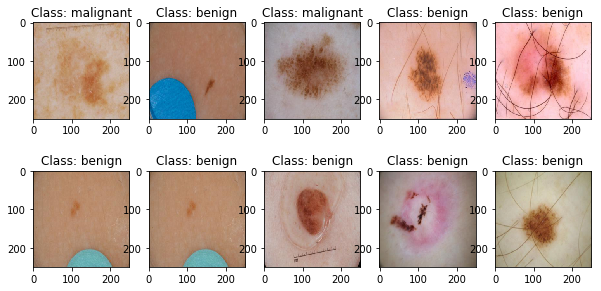

In [10]:
# Create dataset and dataloaders objects
image_datasets, dataloaders = loader.melanomaDataLoader(dataDir, batch_size=batch_size)

# Get dataset objects sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'val']}
print("Size of the dataset objects: ", dataset_sizes)

# Get the class names
class_names = image_datasets['train'].classes
print("Images class names: ", class_names)

# Visualize sample images
print("Sample images:")
loader.showSample(dataloaders, dataset_sizes, class_names)

### Network configuration

In [11]:
###############################
# SELECT MODEL
###############################
#model = models.AlexNet(num_classes=2)
model = models.resnet18()

###############################
# SELECT OPTIMIZER
###############################
finetune = False

learning_rate = 0.001

if finetune:
    optimizer = torch.optim.Adam(list(encoder.parameters())+list(clf.parameters()),lr=learning_rate)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

###############################
# SELECT SCHEDULER
###############################
schedule = True

if schedule:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.1)
else:
    scheduler = None
    
###############################
# SELECT EARLY STOPPING
###############################
earlyStop = False

if earlyStop:
    best_val_loss = np.inf
    best_model = None
    max_epochs = 5 # if no improvement after 5 epochs, stop training
    counter = 0

###############################
# SELECT LOSS FUNCTION
###############################
loss_fn = nn.CrossEntropyLoss()

n_epochs = 20
debug_training_status = False


saving = True

model = model.to(device)

### First Epoch Training Test

In [12]:
# test train and test function
if debug_training_status is True:
    train_loss, train_accuracy = train.train(model, dataloaders['train'], optimizer, loss_fn, device, status = debug_training_status)
    val_loss, val_accuracy, TP, TN, FP, FN  = test_.test(model, dataloaders['val'], loss_fn, device)
    test_loss, test_accuracy, TP, TN, FP, FN = test_.test(model, dataloaders['test'], loss_fn, device)
    print('Test training: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}, test_loss: {:.4f}, test_accuracy: {:.4f}'.format(
        train_loss,
        train_accuracy,
        val_loss,
        val_accuracy,
        test_loss,
        test_accuracy))


### Train and Save Result

In [13]:
    import time
    
    train_losses, train_accuracies = ['train_losses'], ['train_accuracies']
    val_losses, val_accuracies = ['val_losses'], ['val_accuracies']
    learn_rates = ['learning_rate']
    time_epoch = ['execution time']
    
    TPs = ['True Positives']
    TNs = ['True Negatives']
    FPs = ['False Positives']
    FNs = ['False Negatives']
    
    config  = model._get_name() + " " + "_bs=" + str(batch_size)
    
    ##############################
    # Training Epochs            #
    ##############################

    for epoch in range(n_epochs):
        start_time_epoch = time.time()
        
        train_loss, train_accuracy = train.train(model, dataloaders['train'], optimizer, loss_fn, device)
        val_loss, val_accuracy, TP, TN, FP, FN  = test_.test(model, dataloaders['val'], loss_fn, device) 
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        TPs.append(TP)
        TNs.append(TN)
        FPs.append(FP)
        FNs.append(FN)
        
        # SCHEDULER
        learn_rates.append(optimizer.param_groups[0]['lr'])
        if scheduler:
            scheduler.step()
        
        # TIME CALCULATION
        time_last_epoch = time.time() - start_time_epoch
        time_epoch.append(time_last_epoch)
        
        # OTHER METRICS
        
        
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}, learn_rates: {:}, epoch execution time: {:.4f}'.format(
            epoch + 1, n_epochs,
            train_losses[-1],
            train_accuracies[-1],
            val_losses[-1],
            val_accuracies[-1],
            learn_rates[-1],
            time_epoch[-1]))
        
        print('True Positive: {}, True Negative: {}, False Positives: {}, False Negative: {}'.format(
            TPs[-1],
            TNs[-1],
            FPs[-1],
            FNs[-1]))

    ##############################
    # Saving results             #
    ##############################

        if saving is True: #and (epoch+1) % 5 == 0:
            print('...saving...')
            name = config + '_' + loss_fn.__str__() + '_lr=' + str(learning_rate) + '_' +(optimizer.__str__()).split(' ')[0]

            #remove old results
            for filename in glob.glob(results_dir + '/' + name + '*'):
                os.remove(filename)
            for filename in glob.glob(modelstate_dir + '/' + name + '*'):
                os.remove(filename)

            name = name + '_Epoch_' + str(epoch+1)

            # save model weights
            torch.save(model.state_dict(), modelstate_dir + '/' + name + '.pth')

            # save results per epoch
            path = results_dir + '/' + name + '.csv'
            with open(path, 'a') as csvFile:
                writer = csv.writer(csvFile)
                writer.writerow(train_losses)
                writer.writerow(train_accuracies)
                writer.writerow(val_losses)
                writer.writerow(val_accuracies)
                writer.writerow(learn_rates)
                writer.writerow(time_epoch)
                writer.writerow(TPs)
                writer.writerow(TNs)
                writer.writerow(FPs)
                writer.writerow(FNs)
            csvFile.close()
            
    ##############################
    # Early stopping             #
    ##############################
        if earlyStop:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = deepcopy(model)
                counter = 0
            else:
                counter += 1
            if counter == max_epochs:
                print('No improvement for {} epochs; training stopped.'.format(max_epochs))
                break


lenght of dataset : 731
Epoch 1/20: train_loss: 0.7633, train_accuracy: 79.2066, val_loss: 0.4097, val_accuracy: 83.7500, learn_rates: 0.001, epoch execution time: 7.3385
True Positive: 1, True Negative: 66, False Positives: 0, False Negative: 13
...saving...
lenght of dataset : 731
Epoch 2/20: train_loss: 0.4740, train_accuracy: 80.8482, val_loss: 0.4350, val_accuracy: 83.7500, learn_rates: 0.001, epoch execution time: 6.4494
True Positive: 2, True Negative: 65, False Positives: 1, False Negative: 12
...saving...
lenght of dataset : 731
Epoch 3/20: train_loss: 0.4619, train_accuracy: 80.8482, val_loss: 0.4824, val_accuracy: 82.5000, learn_rates: 0.001, epoch execution time: 6.6974
True Positive: 0, True Negative: 66, False Positives: 0, False Negative: 14
...saving...
lenght of dataset : 731
Epoch 4/20: train_loss: 0.4656, train_accuracy: 81.3953, val_loss: 0.5771, val_accuracy: 82.5000, learn_rates: 0.001, epoch execution time: 6.4509
True Positive: 0, True Negative: 66, False Positi

KeyboardInterrupt: 

### Compare models

In [ ]:
files = glob.glob(results_dir + "/_*.csv", recursive=True)

print('Configuration \t'.expandtabs(60), 'Accuracy \t' , 'Specificity \t Sensitivity')
for f in files:
    file_name = f.rsplit('/')[-1]
    parameters = file_name.split('_')
    netname = parameters[1]
    batch_size = parameters[2]
    loss_fn = parameters[3]
    lr = parameters[4]
    optimizer = parameters[5]
    epochs_s = parameters[6]
    with open(f) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        list_training = []
        for row in csv_reader:
            list_training.append(row)
        train_losses = list_training[0]
        train_accuracies = list_training[1]
        val_losses = list_training[2]
        val_accuracies = list_training[3]

        time = list_training[4]

        TP = int(list_training[5][-1])
        TN = int(list_training[6][-1])
        FP = int(list_training[7][-1])
        FN = int(list_training[8][-1])

        specificity = TP/(TP+FN)
        sensitivity = TN/(TN+FP)

        epochs = list(range(1,len(val_accuracies)))

    print("------------------------------------------------------------------------------------------------------------")
    print(netname, batch_size, loss_fn, lr, optimizer, epochs_s, '\t|\t', val_accuracies[2][0:4], '\t|\t', str(specificity)[0:4], '\t|\t', str(sensitivity)[0:4])
    #print("%.2f" % (float(val_accuracies[-1])))


### ROC curve analysis
#### Load model

TODO : Load model doesn't work properly

In [ ]:
model = models.AlexNet(num_classes=2)
batch_size = 8
learning_rate = 0.0001
optimizer = optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

name = model._get_name() + " " + "_bs=" + str(batch_size) + '_' + loss_fn.__str__() + '_lr=' + str(learning_rate) + '_' +(optimizer.__str__()).split(' ')[0]
model_to_load = modelstate_dir +  "/" + name + "*"
#print(name)
#print(model_to_load)
files = glob.glob(model_to_load, recursive=True)
print(files)
if not files:
    print("no model with this configuration was trained/saved")

#load model weights
model.load_state_dict(torch.load(files[-1]))

TODO: give weight to classes for plotting the ROC curve afterward

In [ ]:
def test(model, test_loader, loss_fn, device, weight_for_true=0.5):
    '''
    Tests the model on data from test_loader
    '''
    model.eval()
    test_loss = 0
    n_correct = 0
    n_true_output = 0
    n_false_ouput = 0
    n_TP = 0
    n_TN = 0
    n_FP = 0
    n_FN = 0

    printout = True
    
    weight_for_true = weight_for_true
    weight_for_false = 1-weight_for_true

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = loss_fn(output, labels)
            
            if printout is True:
                print(output)
            printout = False

            _, predicted = torch.max(output.data,1)

            test_loss += loss.item()
            out_argmax = output.argmax(1)

            n_correct += torch.sum(out_argmax == labels).item()
            #n_correct += np.sum(output.argmax(1).numpy()==labels.numpy())

            n_true_output += torch.sum(out_argmax == 1).item()
            n_false_ouput += torch.sum(out_argmax == 0).item()

            n_TP += torch.sum((labels == 1) * (out_argmax == 1)).item()
            n_TN += torch.sum((labels == 0) * (out_argmax == 0)).item()
            n_FP += torch.sum((labels == 0) * (out_argmax == 1)).item()
            n_FN += torch.sum((labels == 1) * (out_argmax == 0)).item()



    average_loss = test_loss / len(test_loader)
    accuracy = 100.0 * n_correct / len(test_loader.dataset)

#   print('Test average loss: {:.4f}, accuracy: {:.3f}'.format(average_loss, accuracy))
    return average_loss, accuracy, n_TP, n_TN, n_FP, n_FN

val_loss, val_accuracy, TP, TN, FP, FN  = test(model, dataloaders['val'], loss_fn, device)

print('val_loss: {:.4f}, val_accuracy: {:.4f}'.format(
    val_loss,
    val_accuracy))
        
print('True Positive: {}, True Negative: {}, False Positives: {}, False Negative: {}'.format(
    TP,
    TN,
    FP,
    FN))